In [34]:
import itertools
import json
import logging
import networkx as nx
import matplotlib.pyplot as plt
from pygenomeviz import GenomeViz
from collections import deque, defaultdict
from IPython.display import Image
from IPython.core.display import HTML

logger = logging.getLogger()
logger.setLevel(logging.WARNING) # set to logging.INFO to follow internal logic or logging.WARNING for silence

## node

Nodes represent segments of sequence.
Nodes have a `node_id`, a `first` position, and a `last` position using BED-style coordinates (although at the moment, the positions aren't used).
The first or last positions may be specified as `*` to denote that they are the first or last node in the path.
Nodes are always represented as top strand reference orientation.  `node_id` are assigned as consecutive letters in top strand reference order.

```
N node_id first last
```

In [35]:
# a complementary node is the same node on the opposite strand
def complementary_node_id(node_id):
  """Use prime to denote the opposite strand"""
  return node_id[:-1] if node_id.endswith("'") else f"{node_id}'"

def minus_strand_node(node):
  """Return the node on the minus strand"""
  return {
    'node_id': complementary_node_id(node['node_id']),
    'first': node['last'],
    'last': node['first']
  }

def load_nodes_data(filename):
  logging.info(f"Loading nodes data from {filename}")
  with open(filename, 'r') as f:
    return json.load(f)
  
def add_nodes(G, nodes_data):
  for node in nodes_data + [minus_strand_node(_) for _ in nodes_data]:
    logging.info(f"Adding node {node['node_id']} to the graph")
    G.add_node(node['node_id'], first=node['first'], last=node['last'])

## edge

Edges are connections between nodes.

```
E node_id1 node_id2 explicit read_support
```

- explicit/implicit (bool) is a flag that indicates whether the edge is explicit (true) or implicit (false)
  - explicit edges pass from node to node with a discontinuity in position, i.e., the right end of node_id1 is not the same as the left end of node_id2
  - implicit edges pass from node to node without a discontinuity in position; i.e. the right end of node_id1 is directly connected to the left end of node_id2 in the same orientation
  - edges representing deletions or insertions always connect opposite ends in the same orientation
  - edges representing inversions always connect ends in opposite orientations
- read_support is the number (int) of reads supporting the edge; not using this for now, but we could eventually use it to allow an explicit edge to be traversed more than once
  - for implicit edges, read_support is the read depth at the position of the edge
  - for explicit edges, read_support is the number of reads that span the edge
- edges are bidirectional, i.e., an edge exiting node1 on the right and entering node2 on the left in the same orientation is equivalent to an edge exiting node2 on the right and entering node1 on the left in the same orientation; we implement this by explicity adding the complementary edge to the complementary node
- paths travel from "left" to "right"

In [36]:
def load_edges_data(filename):
  logging.info(f"Loading edges data from {filename}")
  with open(filename, 'r') as f:
    return json.load(f)

def generate_implicit_edge_data(nodes_data):
  return [
    {
      'node_id1': first['node_id'],
      'node_id2': second['node_id'],
      'explicit': False,
      'read_support': 5
    }
    for first, second in zip(nodes_data, nodes_data[1:])
  ]

def add_edges(G, edges_data):
  for edge in edges_data:
  # we're going to add the edge twice, once for each direction
  # since it's still just a single edge, we'll assign a unique id
  # use the unique_id later to require that an explicit edge is only traversed once
    unique_edge_id = f"{edge['node_id1']}_{edge['node_id2']}"
    logging.info(f"Adding {'explicit' if edge['explicit'] else 'implicit'} edge ({edge['node_id1']}, {edge['node_id2']}) with unique id {unique_edge_id}")
    G.add_edge(
      edge['node_id1'],
      edge['node_id2'],
      explicit=edge['explicit'],
      read_support=edge['read_support'],
      unique_id=unique_edge_id
    )
    logging.info(f"Adding {'explicit' if edge['explicit'] else 'implicit'} edge ({complementary_node_id(edge['node_id2'])}, {complementary_node_id(edge['node_id1'])}) with unique id {unique_edge_id}")
    G.add_edge(
      complementary_node_id(edge['node_id2']),
      complementary_node_id(edge['node_id1']),
      explicit=edge['explicit'],
      read_support=edge['read_support'],
      unique_id=unique_edge_id
    )


## paths

Paths are sequences of nodes.  We're interested in paths starting at the first node and ending at the last node.

Reference paths involving only implicit edges are considered trivial.

Paths that do not use all explicit edges once and only once are considered invalid.

In [37]:
def plot_graph(G, path=None, explicit_edges=None):
  pos = nx.planar_layout(G)
  nx.draw_networkx(G, pos=pos, with_labels=True)
  if explicit_edges:
    nx.draw_networkx_edges(G, pos, edgelist=explicit_edges, edge_color='b', width=2)
  if path:
    path_edges = list(zip(path,path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
  plt.show()

def print_paths(title, paths):
  print(f"{title}:")
  if paths:
    for path in sorted(paths, key=len):
      print(''.join(path))
  else:
    print("None")
  print("\n")

def find_paths_with_cycles(G, source, target):
  """Find all paths from source through target that include a cycle"""
  cycle_paths = []
  for cycle in nx.simple_cycles(G):
    logging.info(f"Found cycle {''.join(cycle)}")
    for node in cycle:
      cycle_path = deque(cycle)
      cycle_path.rotate(-cycle.index(node))
      logging.info(f"Found cycle path {''.join(list(cycle_path) + [cycle[cycle.index(node)]])}")
      cycle_path.popleft()
      entrance_paths = list(nx.all_simple_paths(G, source, node))
      logging.info(f"Found entrance paths {','.join([''.join(entrance_path) for entrance_path in entrance_paths])}")
      exit_paths = list(nx.all_simple_paths(G, node, target))
      logging.info(f"Found exit paths {','.join([''.join(exit_path) for exit_path in exit_paths])}")
      paths = [entrance_path + list(cycle_path) + exit_path for entrance_path in entrance_paths for exit_path in exit_paths]
      logging.info(f"Found paths {','.join([''.join(path) for path in paths])}")
      cycle_paths.extend(paths)
  cycle_paths.sort()
  return list(cycle_paths for cycle_paths,_ in itertools.groupby(cycle_paths))


def filter_paths(G, source, target, paths_with_cycles=[]):
    """Check each path to ensure that each explicit edge is used once and only once"""
    filtered_paths = []
    for path in list(nx.all_simple_paths(G, source, target)) + paths_with_cycles:
        logging.info(f"Checking path {''.join(path)}")
        explicit_edges = list(set([d['unique_id'] for _, _, d in G.edges(data=True) if d['explicit']]))
        logging.info(f"Explicit edges: {explicit_edges}")
        # for each edge in path
        for i in range(len(path)-1):
            # if the edge is explicit and not still available, remove the path
            if G.edges[path[i], path[i+1]]['explicit'] and G.edges[path[i], path[i+1]]['unique_id'] not in explicit_edges:
                logging.info(f"{path} is invalid because explicit edge {G.edges[path[i], path[i+1]]['unique_id']} is not available to traverse")
                break
            elif G.edges[path[i], path[i+1]]['explicit']:
                logging.info(f"Traversed edge {G.edges[path[i], path[i+1]]['unique_id']} and removing from available edges")
                explicit_edges.remove(G.edges[path[i], path[i+1]]['unique_id'])
        logging.info(f"Untraversed explicit edges: {explicit_edges}")
        if not explicit_edges:
            logging.info(f"Path {''.join(path)} is valid and nontrivial")
            filtered_paths.append(path)
        else:
            logging.info(f"Path {''.join(path)} is invalid or trivial")
    return filtered_paths


In [38]:
def node_feature_lookup(nodes_data):
  lookup = defaultdict(dict)
  for node in nodes_data:
    lookup[node['node_id']] = node
    lookup[node['node_id']]['size'] = node['last'] - node['first']
    lookup[node['node_id']]['strand'] = 1
    lookup[complementary_node_id(node['node_id'])] = minus_strand_node(node)
    lookup[complementary_node_id(node['node_id'])]['size'] = node['last'] - node['first']
    lookup[complementary_node_id(node['node_id'])]['strand'] = -1
  return lookup

def total_path_size(path, node_feature_lookup):
  return sum([node_feature_lookup[node]['size'] for node in path])

In [39]:
def genomeviz_path(sample_name, path, nodes_data, node_feature_lookup):
  def get_features(path, node_feature_lookup):
    features = []
    start = 0
    for node in path:
      features.append(
        (
          node_feature_lookup[node]['node_id'],
          start,
          start+node_feature_lookup[node]['size'],
          node_feature_lookup[node]['strand']
        )
      )
      start += node_feature_lookup[node]['size']
    return tuple(features)

  haplotype_list = [
    dict(
      name="reference",
      size=total_path_size([node['node_id'] for node in nodes_data], node_feature_lookup),
      features=(tuple([(node['node_id'], node['first'], node['last'], 1) for node in nodes_data]))
    )
  ]

  haplotype_list.extend(
    [
      dict(
        name=''.join(path),
        size=total_path_size(path, node_feature_lookup),
        features=get_features(path, node_feature_lookup)
      )
    ]
  )

  gv = GenomeViz(track_align_type="center")
  gv.set_scale_bar()

  for haplotype in haplotype_list:
      name, size, features = haplotype["name"], haplotype["size"], haplotype["features"]
      track = gv.add_feature_track(name, size)
      track.add_sublabel()
      for feature in features:
          label, start, end, strand = feature
          track.add_feature(start, end, strand, plotstyle="bigarrow", lw=1, label=label, text_kws=dict(rotation=0, vpos="top", hpos="center"))

  def link_features(gv, path_list):
    reference_features = {feature[0]: feature for feature in haplotype_list[0]['features']}
    for haplotype in haplotype_list[1:]:
      for haplotype_feature in haplotype['features']:
        if haplotype_feature[0] in reference_features:
          gv.add_link(
              (
                'reference',
                reference_features[haplotype_feature[0]][1],
                reference_features[haplotype_feature[0]][2]
              ),
              (
                haplotype['name'],
                haplotype_feature[1],
                haplotype_feature[2]
              ),
              alpha=0.3, color="skyblue", inverted_color="lime", curve=True
            )
        if complementary_node_id(haplotype_feature[0]) in reference_features:
          gv.add_link(
            (
              'reference',
              reference_features[complementary_node_id(haplotype_feature[0])][2],
              reference_features[complementary_node_id(haplotype_feature[0])][1]
            ),
            (
              haplotype['name'],
              haplotype_feature[1],
              haplotype_feature[2]
            ),
            alpha=0.3, color="skyblue", inverted_color="lime", curve=True
          )

  link_features(gv, haplotype_list)
  gv.savefig(f"{sample_name}-{''.join(path)}.png")
  display(Image(filename=f"./{sample_name}-{''.join(path)}.png"))

In [40]:
def solve_graph(nodes_data_file_path, edges_data_file_path, sample_name):
  # create graph
  G = nx.DiGraph()
  #G = nx.MultiDiGraph()

  # load node data
  nodes_data = load_nodes_data(nodes_data_file_path)
  add_nodes(G, nodes_data)
  node_lookup = node_feature_lookup(nodes_data)

  first_node = nodes_data[0]['node_id']
  last_node = nodes_data[-1]['node_id']

  # load edge data
  explicit_edges_data = load_edges_data(edges_data_file_path)
  implicit_edges_data = generate_implicit_edge_data(nodes_data)
  add_edges(G, explicit_edges_data + implicit_edges_data)

  # print simple paths
  simple_paths = list(nx.all_simple_paths(G, first_node, last_node))
  print_paths("All simple paths", simple_paths)

  # find paths with cycles
  paths_with_cycles = find_paths_with_cycles(G, first_node, last_node)
  print_paths("Paths with cycles", paths_with_cycles)

  # print filtered paths that use all explicit edges once and only once
  nontrivial_paths = filter_paths(G, first_node, last_node, paths_with_cycles)
  print_paths("Valid nontrivial paths", nontrivial_paths)

  #plot_graph(G, path=None, explicit_edges=[(u,v) for u,v,d in G.edges(data=True) if d['explicit']])
  for path in sorted(nontrivial_paths, key=len):
    plot_graph(G, path=path)
    genomeviz_path(sample_name, path, nodes_data, node_lookup)

All simple paths:
ABD
ABCD


Paths with cycles:
None


Valid nontrivial paths:
ABD




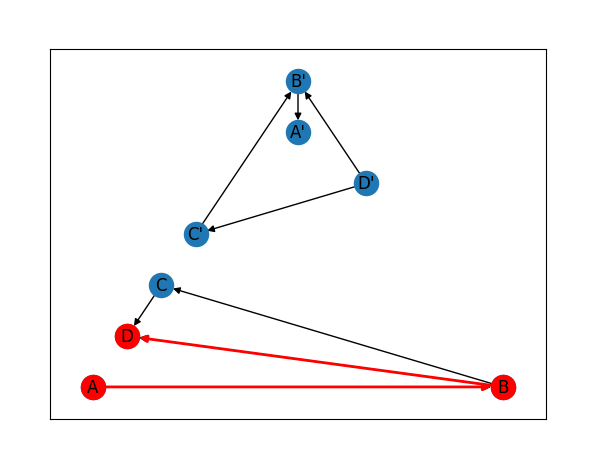

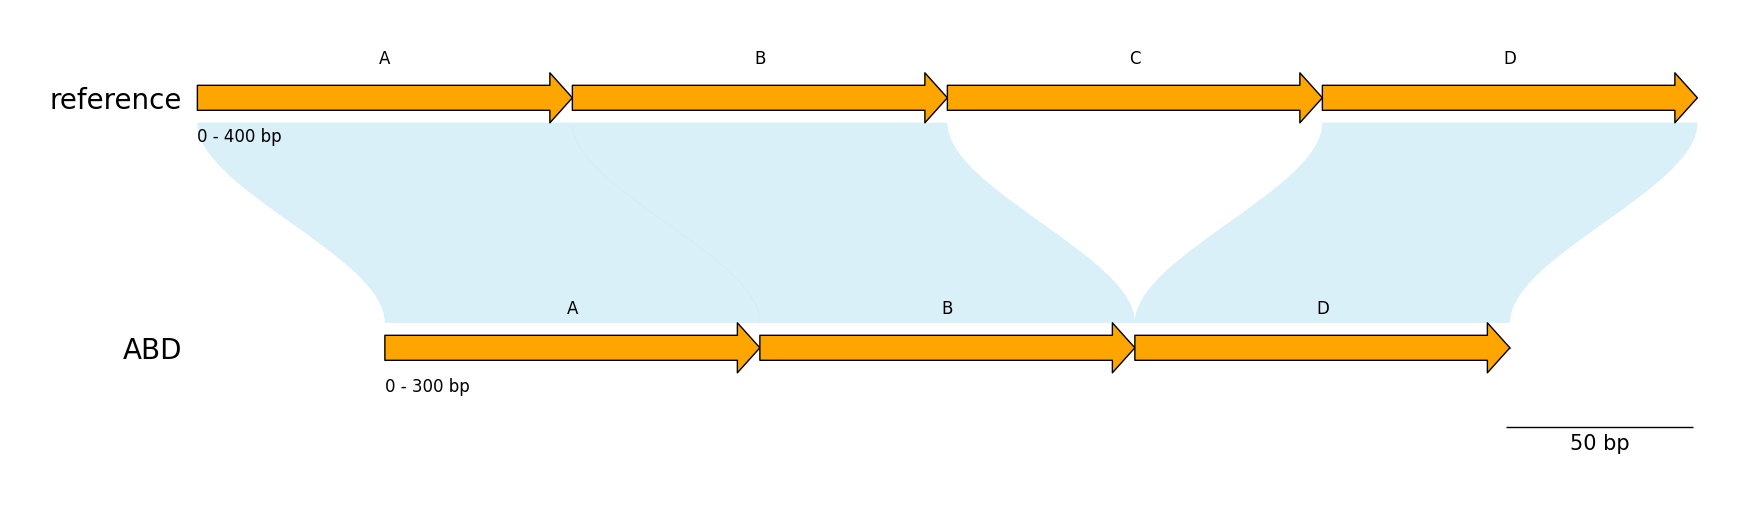

In [41]:
# 4 segments, simple heterozygous deletion of segment C

solve_graph('nodes/simple_nodes.json', 'edges/simple_deletion.json', 'simple_deletion')
# for simple deletions, the two graphs should be disconnected because no explicit edges connect them
# we want the answer ABD

All simple paths:
ABCD


Paths with cycles:
ABCBCD


Valid nontrivial paths:
ABCBCD




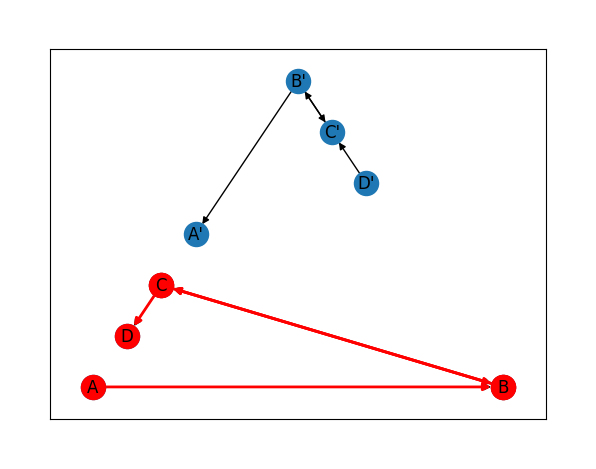

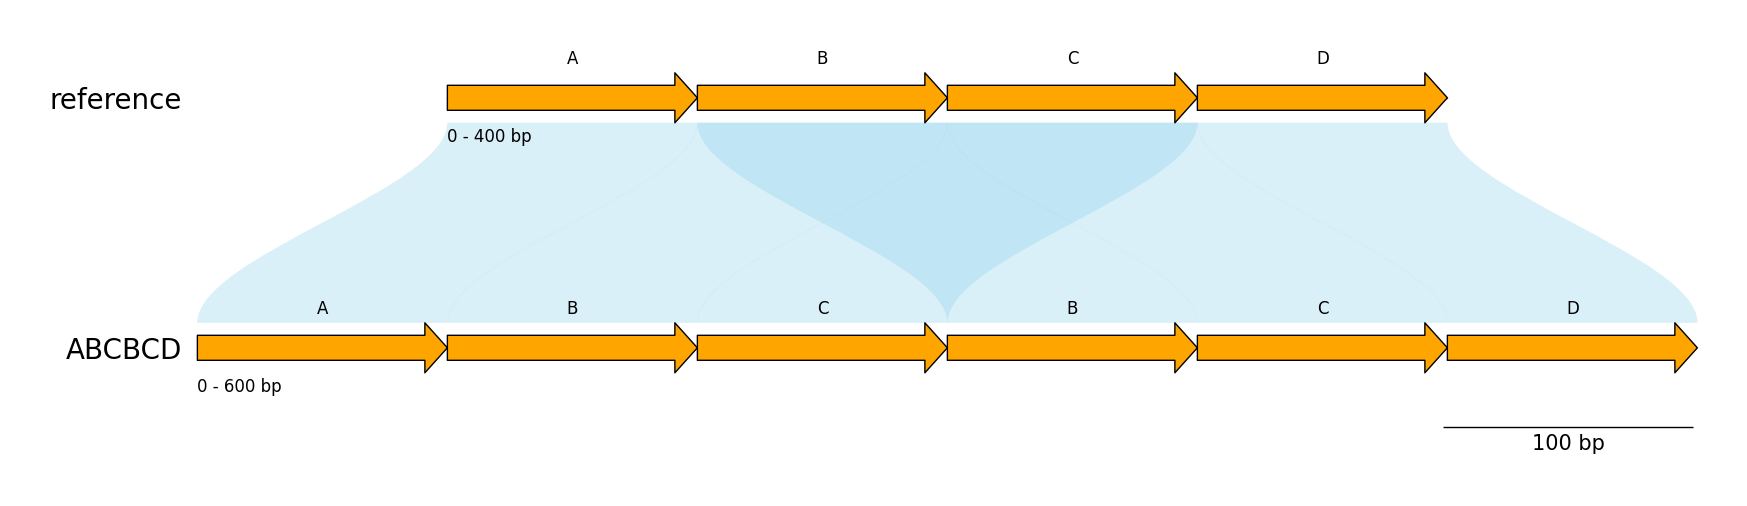

In [42]:
# 4 segments, simple heterozygous duplication of segments B and C

solve_graph('nodes/simple_nodes.json', 'edges/simple_duplication.json', 'simple_duplication')
# for simple duplications, the two graphs should be disconnected because no explicit edges connect them
# there are bidirectional edges along the duplicated edge, leading to a cycle
# we actually want to allow explicit edges (by their unique_id) to be traversed once and only once
# which could prevent recursion in the cycles
# we want the answer ABCBCD

All simple paths:
ABCD
ABC'B'D
ABCB'D


Paths with cycles:
None


Valid nontrivial paths:
ABC'B'D
ABCB'D




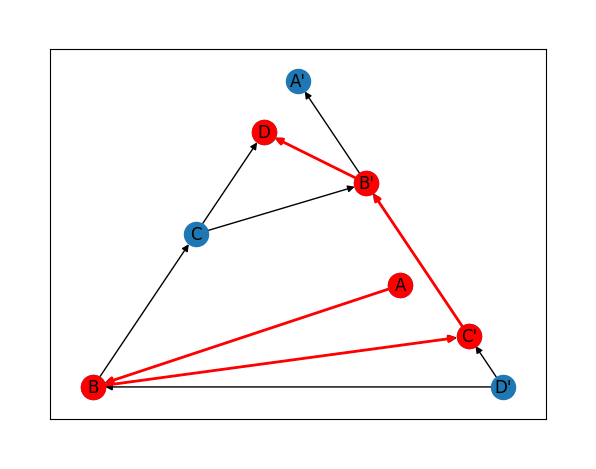

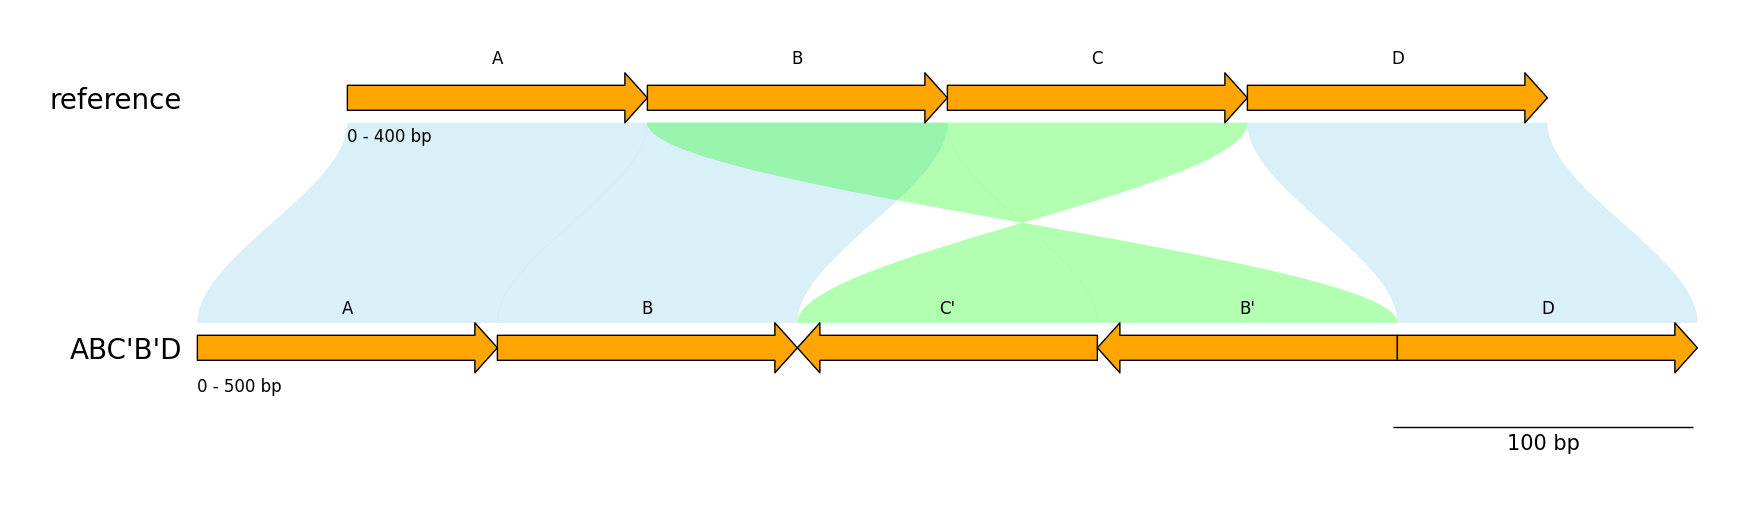

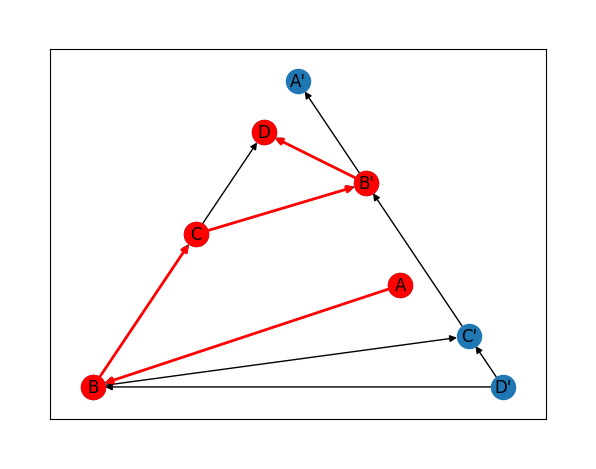

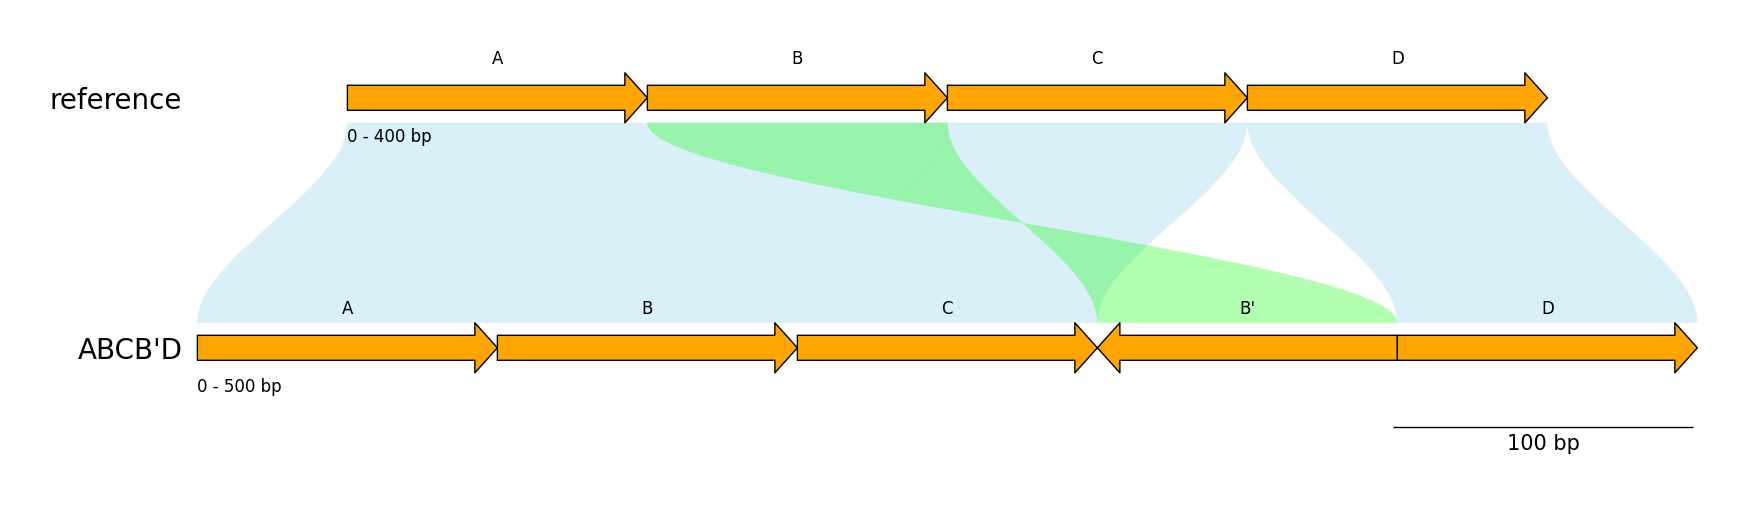

In [43]:
# 4 segments, heterozygous inversion involving breakpoints C->B' and B'->D

solve_graph('nodes/simple_nodes.json', 'edges/simple_inversion.json', 'simple_inversion')
# inversions connect the two graphs
# we want the answer ABCB'D

All simple paths:
ABG'I
AD'BG'I
ABCDEFGHI
AD'BCDEFGHI
AD'C'B'DEFGHI
ABG'F'E'D'C'B'DEFGHI


Paths with cycles:
ABG'F'E'D'BG'I
AD'BG'F'E'D'BG'I
ABCDEFGB'DEFGHI
ABG'F'E'D'BCDEFGHI
ABG'F'E'D'BG'F'E'D'BG'I
AD'BCDEFGB'DEFGHI
AD'BG'F'E'D'BCDEFGHI
AD'BG'F'E'D'BG'F'E'D'BG'I
AD'BG'F'E'D'C'B'DEFGHI
AD'C'B'DEFGB'DEFGHI
ABCDEFGB'DEFGB'DEFGHI
ABG'F'E'D'BG'F'E'D'BCDEFGHI
ABG'F'E'D'BG'F'E'D'C'B'DEFGHI
ABG'F'E'D'C'B'DEFGB'DEFGHI
AD'BCDEFGB'DEFGB'DEFGHI
AD'BG'F'E'D'BG'F'E'D'BCDEFGHI
AD'BG'F'E'D'BG'F'E'D'C'B'DEFGHI


Valid nontrivial paths:
AD'BG'I




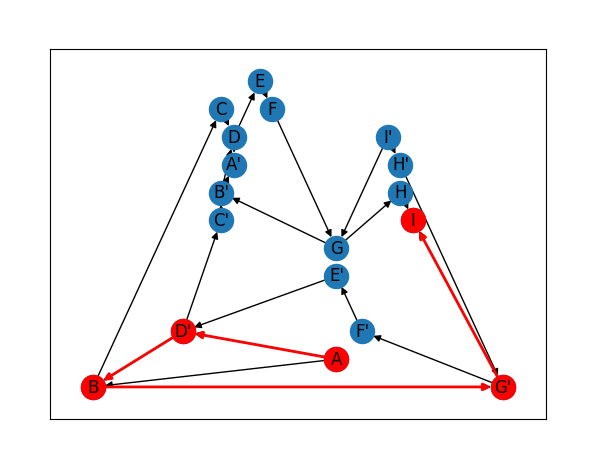

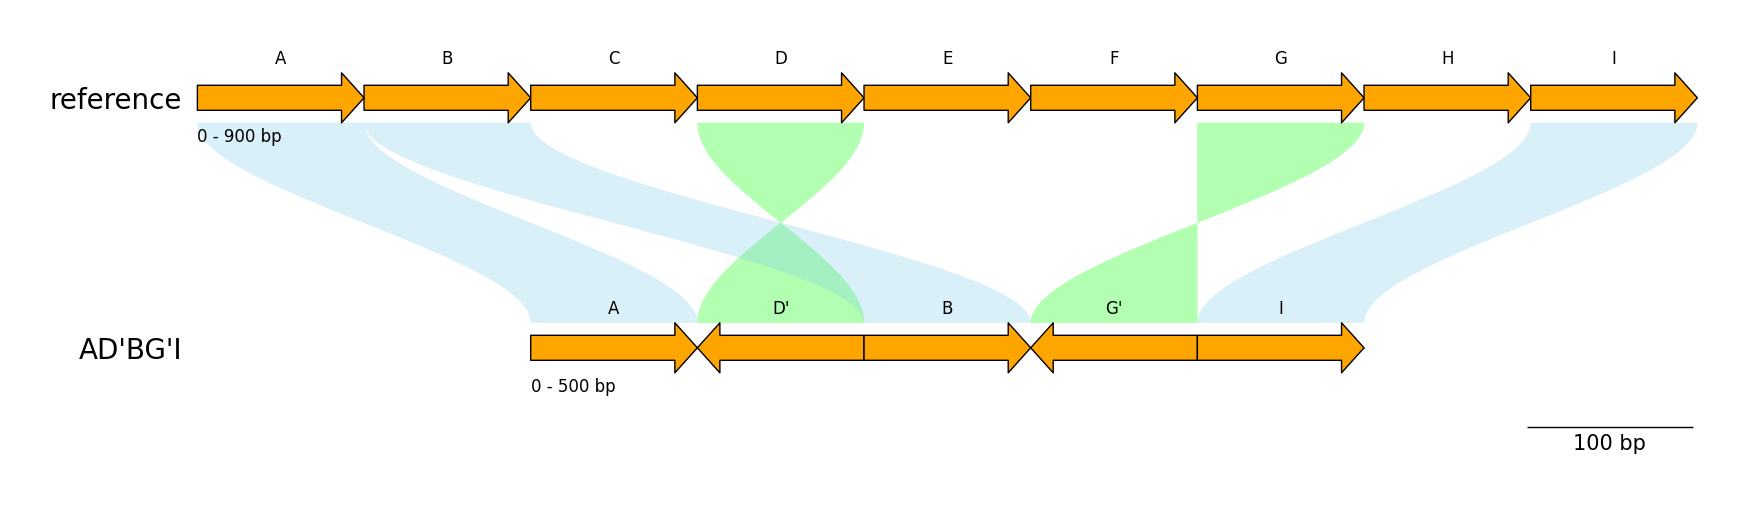

In [44]:
# 9 segments, complex heterozygous event with deletions and inverted BNDs based on real data

solve_graph('nodes/complex_nodes.json', 'edges/complex.json', 'complex')
# we want the answer AD'BG'I